<a href="https://colab.research.google.com/github/arielfaur/prediccion-precio-propiedades-fmap-2020/blob/master/precio_propiedades_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, train_test_split

text_mining_keywords = ['cochera', 'sum', 'parrilla', 'pileta']


def vectorize_descripcion(df: pd.DataFrame):
    descripcion = df['descripcion']
    descripcion[descripcion.isna()] = ''

    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True)  
    vectorizer.fit(text_mining_keywords)

    # hot encoding de los resultados
    df_countvectorizer = vectorizer.transform(descripcion)

    desc = pd.DataFrame(df_countvectorizer.toarray())
    desc.columns = text_mining_keywords
    
    df.drop(['descripcion'], axis=1, inplace=True)
    return(pd.concat([df, desc], axis=1))
    

def preprocessing(df: pd.DataFrame):
    # guardar los id
    ids = df['id']

    # eliminar columnas innecesarias del modelo
    df.drop(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'subbarrio', 'titulo'],axis=1, inplace=True)

    df = vectorize_descripcion(df)

    return ids, df


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df['precio']
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


def make_transformer_pipeline():
    # KNNImputer tarda una eternidad...no sé por qué !!!
    # from sklearn.impute import KNNImputer
    # imp = KNNImputer(n_neighbors=3, weights="distance")

    # # Usamos SimpleImputer en vez de KNNImputer
    # imp_X = SimpleImputer(missing_values = np.nan, strategy='mean')
    # sc_X = StandardScaler()

    # return make_pipeline(column_transformer, imp_X, sc_X)

    
    ## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
    numeric_features = ['lat', 'lon', 'habitaciones', 'dormitorios', 'banios',
       'sup_total', 'sup_cubierta', 'cochera', 'sum', 'parrilla',
       'pileta']
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_features = ['barrio']
    categorical_transformer = make_pipeline(
        #SimpleImputer(strategy='constant', fill_value='missing'),
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features)
    )    

def make_model_pipeline():
    transformer = make_transformer_pipeline()
    rfr = RandomForestRegressor(n_estimators=50, max_depth=22, min_samples_split=3, random_state = 5)
    
    return make_pipeline(transformer, rfr)

def create_train_model(df: pd.DataFrame):
    ids, df = preprocessing(df)
    pipeline = make_model_pipeline()

    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return ids, df, model

def plot_test_predictions(y_test, y_pred):
    # graficar predicciones contra datos actuales
    plt.figure(figsize = (25,15))
    plot_k = sns.scatterplot(y_test, y_pred)
    plot_k.set(xlabel='Precio test', ylabel='Precio predicción')
    # graficar la identidad
    x_plot = np.linspace(0,np.max(y_test),1000)
    y_plot = x_plot
    plt.plot(x_plot, y_plot, color='r')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df_train = pd.read_excel('https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/propiedades_entrenamiento.xlsx')
ids_train, df_train, model = create_train_model(df_train)
df_train.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lat,lon,barrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,precio,cochera,sum,parrilla,pileta
0,-34.606891,-58.409890,Almagro,3.0,NaN,2.0,108.0,108.0,150000,0,0,0,0
1,-34.604912,-58.417065,Almagro,3.0,1.0,2.0,72.0,63.0,144000,1,0,0,0
2,-34.600886,-58.431204,Villa Crespo,3.0,2.0,1.0,57.0,57.0,145000,0,0,0,0
3,-34.628760,-58.453224,Flores,4.0,3.0,3.0,128.0,117.0,585000,0,0,1,0
4,-34.572144,-58.480173,Villa Urquiza,3.0,NaN,2.0,NaN,60.0,237000,0,0,0,0


In [5]:
X_train, X_test, y_train, y_test = split_data(df_train)

scores = cross_validate(model, X_train, y_train, cv=5, scoring=('r2', 'neg_root_mean_squared_error'))

print(scores['test_neg_root_mean_squared_error'])
print(scores['test_r2'])



[-104351.05128174 -103206.88293643 -126221.05540874 -132235.76892957
 -145050.74406878]
[0.84636978 0.87219649 0.81718433 0.79348563 0.73837253]


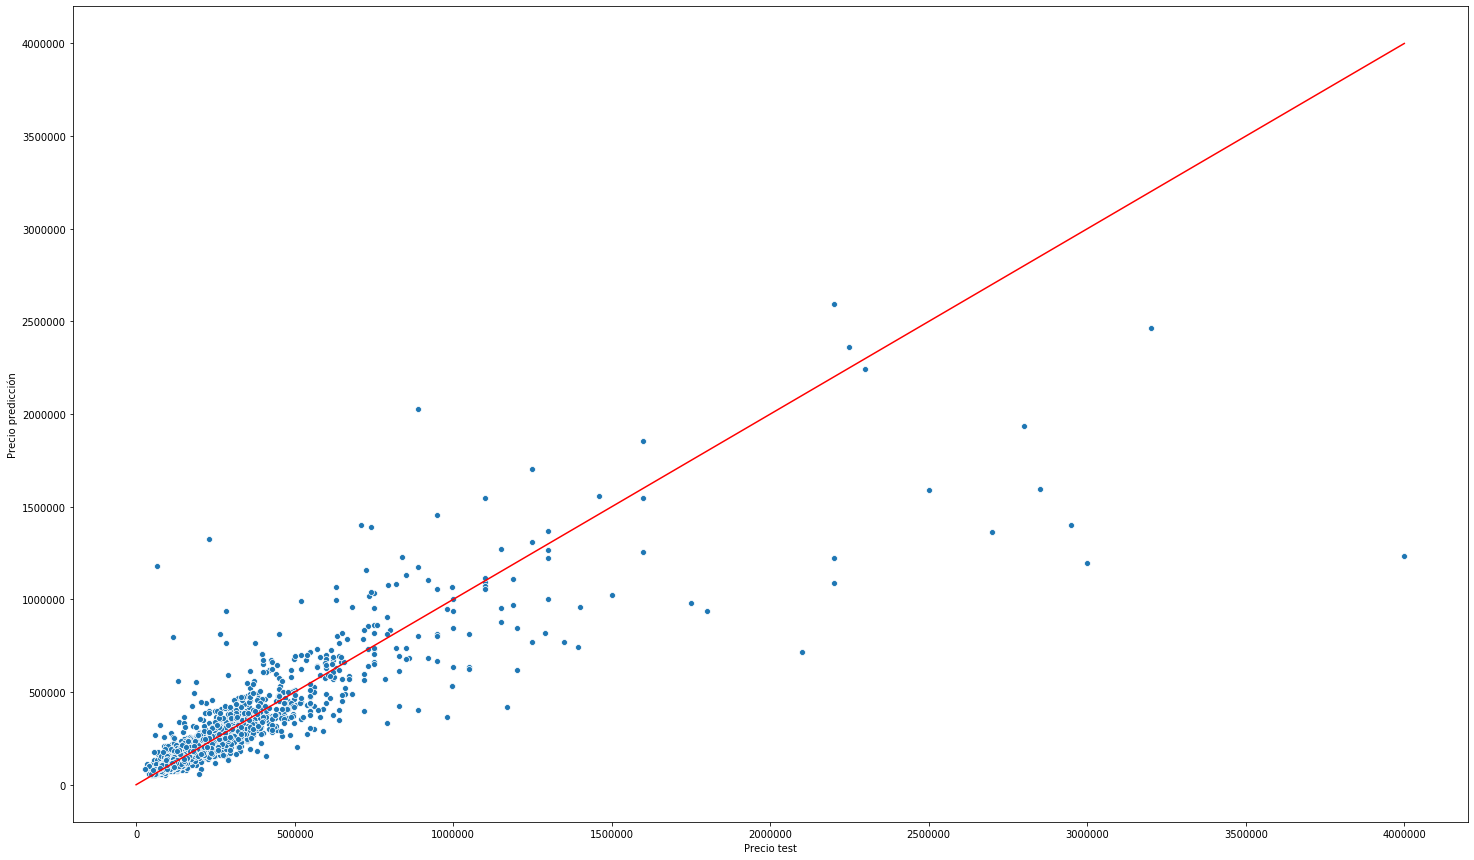

In [ ]:

y_pred = cross_val_predict(model, X_test, y_test, cv=5)
plot_test_predictions(y_test, y_pred)




In [ ]:
df_test = pd.read_excel('propiedades_prueba.xlsx')
ids, df_test = preprocessing(df_test)



In [ ]:
model.fit(X_train, y_train)


In [ ]:
predicted = model.predict(df_test)
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(predicted).astype(int) })

In [ ]:
data


In [ ]:
data.to_csv('propiedades.csv', index=False)
